# **Chapter 7: Ensemble Learning and Random Forests**
# **Gambaran Umum Ensemble Learning**

**Ensemble Learning** menggabungkan prediksi dari beberapa model (disebut *weak learners*) untuk menghasilkan prediktor yang lebih akurat dan andal (*strong learner*).

Beberapa metode ensemble umum:

- **Voting** (keras dan lunak)
- **Bagging** (Bootstrap Aggregating)
- **Boosting**
- **Stacking**

**Ide utama:** Menggabungkan model yang beragam untuk mengurangi variansi dan/atau bias.

### Contoh: Hard voting classifier menggabungkan Logistic Regression, Random Forest, dan SVM


In [1]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'{clf.__class__.__name__} Accuracy: {accuracy_score(y_test, y_pred):.3f}')


LogisticRegression Accuracy: 0.860
RandomForestClassifier Accuracy: 0.907
SVC Accuracy: 0.907
VotingClassifier Accuracy: 0.913


# **Hard Voting vs Soft Voting**
- Hard Voting: Memilih kelas berdasarkan suara terbanyak.
- Soft Voting: Memilih kelas berdasarkan probabilitas rata-rata tertinggi.

Soft voting sering menghasilkan akurasi yang lebih baik karena menggunakan bobot kepercayaan.

In [2]:
voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

voting_clf_soft.fit(X_train, y_train)
y_pred_soft = voting_clf_soft.predict(X_test)
print(f"Soft Voting Classifier Accuracy: {accuracy_score(y_test, y_pred_soft):.3f}")


Soft Voting Classifier Accuracy: 0.933


# **Bagging dan Pastin**g
Melatih beberapa model dasar pada sampel acak dari data.

Bagging: Sampling dengan pengembalian (bootstrap).

Pasting: Sampling tanpa pengembalian.

Output digabungkan melalui rata-rata (untuk regresi) atau voting (untuk klasifikasi).

### **Contoh: Bagging dengan Decision Tree**

In [3]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=1,
    random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred_bag = bag_clf.predict(X_test)
print(f"Bagging Classifier Accuracy: {accuracy_score(y_test, y_pred_bag):.3f}")


Bagging Classifier Accuracy: 0.920


# **Evaluasi Out-of-Bag (OOB)**
Sampel yang tidak termasuk dalam data bootstrap disebut out-of-bag. OOB dapat digunakan sebagai data validasi tanpa perlu dataset terpisah.

Scikit-learn mendukung estimasi skor OOB dengan BaggingClassifier.

In [4]:
bag_clf_oob = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    bootstrap=True,
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

bag_clf_oob.fit(X_train, y_train)
print(f"OOB Score: {bag_clf_oob.oob_score_:.3f}")


OOB Score: 0.891


# **Random Patches dan Random Subspaces**
Sampling fitur bersamaan dengan instance dapat meningkatkan keragaman model.
- Random Patches: Sampling instance dan fitur (cocok untuk data berdimensi tinggi).
- Random Subspaces: Sampling fitur saja.

Parameter ini dapat diatur dalam BaggingClassifier.

# **Random Forests**
Kumpulan decision tree yang dilatih melalui bagging dengan tambahan elemen acak:
- Pada setiap split, pertimbangkan subset acak dari fitur.
- Menurunkan korelasi antar pohon, mengurangi variansi, dan meningkatkan generalisasi.
- Praktis dan efisien dengan RandomForestClassifier dan RandomForestRegressor.

In [5]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")


Random Forest Accuracy: 0.913


# **Extra-Trees**
Mirip Random Forest, tetapi menggunakan lebih banyak acakan dalam pemilihan ambang split.
- Cepat dilatih
- Mengorbankan sedikit bias untuk variansi yang lebih rendah


# **Pentingnya Fitur (Feature Importance)**
Random Forest dapat mengestimasi pentingnya fitur berdasarkan penurunan impurity rata-rata.

### **Contoh: Visualisasi feature importance pada dataset iris**

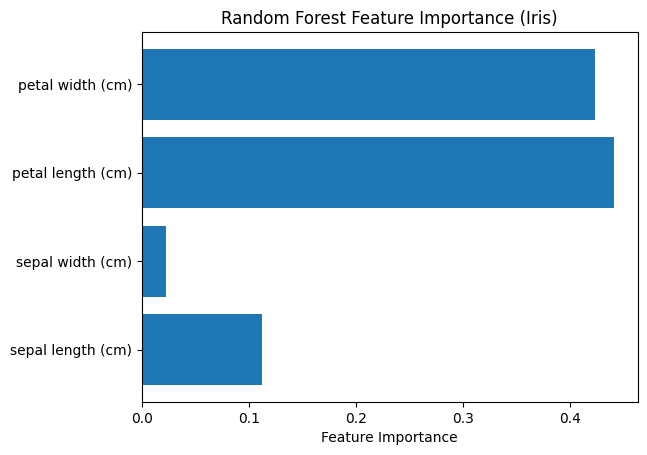

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
rf_clf_full = RandomForestClassifier(n_estimators=500, random_state=42)
rf_clf_full.fit(iris.data, iris.target)
importances = rf_clf_full.feature_importances_

plt.barh(iris.feature_names, importances)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance (Iris)')
plt.show()


# **Boosting**
Boosting melatih model secara berurutan, di mana setiap model baru mencoba memperbaiki kesalahan dari model sebelumnya.
- AdaBoost: Memberi bobot lebih pada sampel yang sulit diklasifikasikan
- Gradient Boosting: Menyesuaikan prediktor baru terhadap kesalahan residual

> Catatan: Boosting tidak dapat diparalelkan karena prosesnya bersifat sekuensial.



In [7]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train, y_train)
print(f"AdaBoost Accuracy: {accuracy_score(y_test, ada_clf.predict(X_test)):.3f}")


AdaBoost Accuracy: 0.880


# **Stacking**
Stacking melatih sebuah meta-model (disebut blender) untuk menggabungkan prediksi dari model-model dasar.
- Model dasar dilatih pada sebagian data pelatihan
- Meta-model dilatih pada prediksi dari model dasar pada data validasi
- Lebih fleksibel daripada voting biasa
> Tidak secara langsung didukung di Scikit-learn, namun pustaka open-source seperti DESlib tersedia.